<a href="https://colab.research.google.com/github/ngotancuong/datamining/blob/main/S5_Building_Kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kernels and Extrapolation
Proper kernel design is very important if you want to fit the data well using Support Vector Machines or Gaussian Processes. Here, we are going to build some artificial regression datasets and try to find or build good kernels. We'll also look at how well these kernels can extrapolate to 'future' data.

## A simple wave
The first artificial dataset is shown below. It is a sine wave with added noise.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import sys
os.chdir('/content/gdrive/My Drive/Teaching-task/myDM-MLcourse/ml-course/studies')
sys.path.append("/content/gdrive/My Drive/Teaching-task/myDM-MLcourse/ml-course/studies")
!pwd

/content/gdrive/My Drive/Teaching-task/myDM-MLcourse/ml-course/studies


In [ ]:
!pip install openml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.1-py3-none-any.whl size=146923 sha256=f25c1c26c22d096b38662b7a53ef7641ad9eb61373ab6cc7de2ad1f79a9a4805
  Stored in directory: /root/.cache/pip/wheels/75/bc/fd/739778254a2881ef96b139d0aaf60c6d4f9130bb1459b48f10
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=7317570bc50fef492e6d04b6da9bc038b0153298909af3cb00f713fe6bda35d7
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built openml liac-arff


In [ ]:
import os

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = True # Set to True for interactive plots
if interactive:
    fig_scale = 0.5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.4
    plt.rcParams.update(print_config)

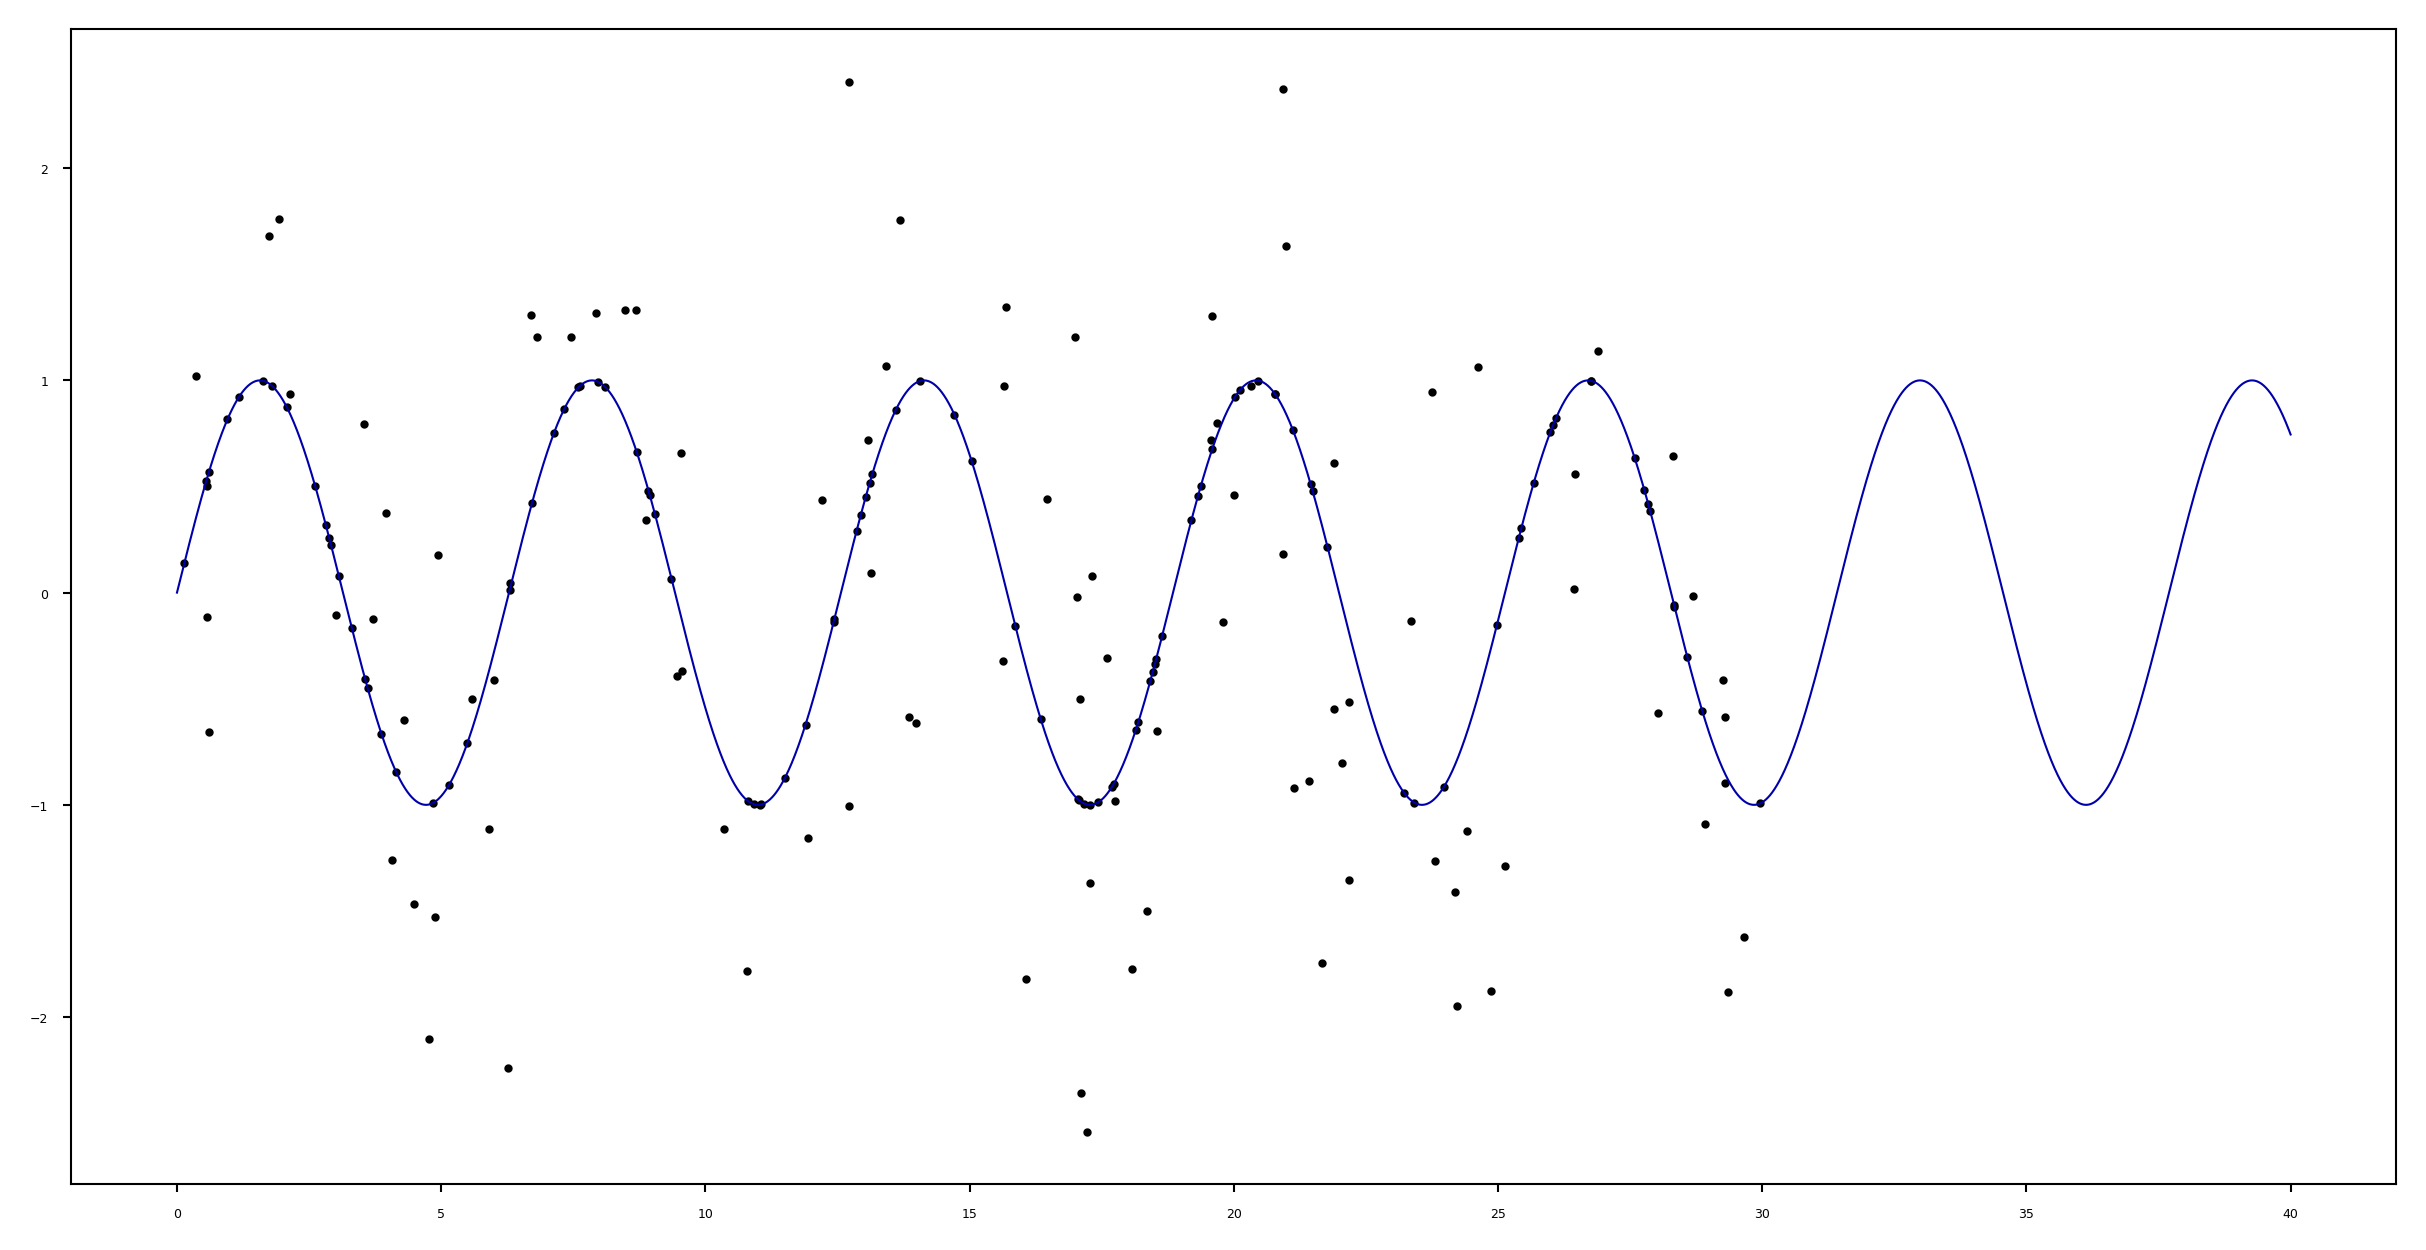

In [ ]:
# Generate sample data
rng = np.random.RandomState(0) # Random seed, for reproducibility
X = 30 * rng.rand(200, 1)
y = np.sin(X).ravel()
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2) # adds noise

X_plot = np.linspace(0, 40, 10000)[:, None] # A larger range to evaluate on
true_y = np.sin(X_plot) # and the 'true' target function

plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y);

First, we implement several kernels and then use them to fit the data. Of course, we could use the ones that are included in sklearn, but here we want to implement them ourselves for better understanding.

Linear kernel: $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \mathbf{x}_i \cdot \mathbf{x}_j$$
Polynomial kernel (degree $d$): $$k(\mathbf{x}_i,\,\mathbf{x}_j) = (\mathbf{x}_i \cdot \mathbf{x}_j)^d$$
RBF kernel (width $\gamma$):   $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \exp \left( -\gamma\,\left|\left|x_i-x_j\right|\right|\right)$$
ExpSine (Exponential Sine Squared) kernel (length scale $\Gamma$, periodicity $P$): $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \exp \left( -\Gamma\,\sin^2\left[\frac{\pi}{P}\,\left|\left|x_i-x_j\right|\right|\right]\right)$$

ExpSine with different a definition of $\Gamma$ (easier to tune): $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \exp \left( -2\,\left[\frac{\sin \left[\frac{\pi}{P}\,\left|\left|x_i-x_j\right|\right|\right]}{\Gamma}\right]^2\right)$$

    - Think about what $\Gamma$ and $P$ represent. Can you improve the fit by manually adjusting them? Explain your findings.
    - Optimize $\Gamma$ and periodicity $P$ (using `true_y` as the ground truth). Use a grid search or random search, $\Gamma \in [0,1]$, $P \in [1,100]$, try at least 5 values for each.

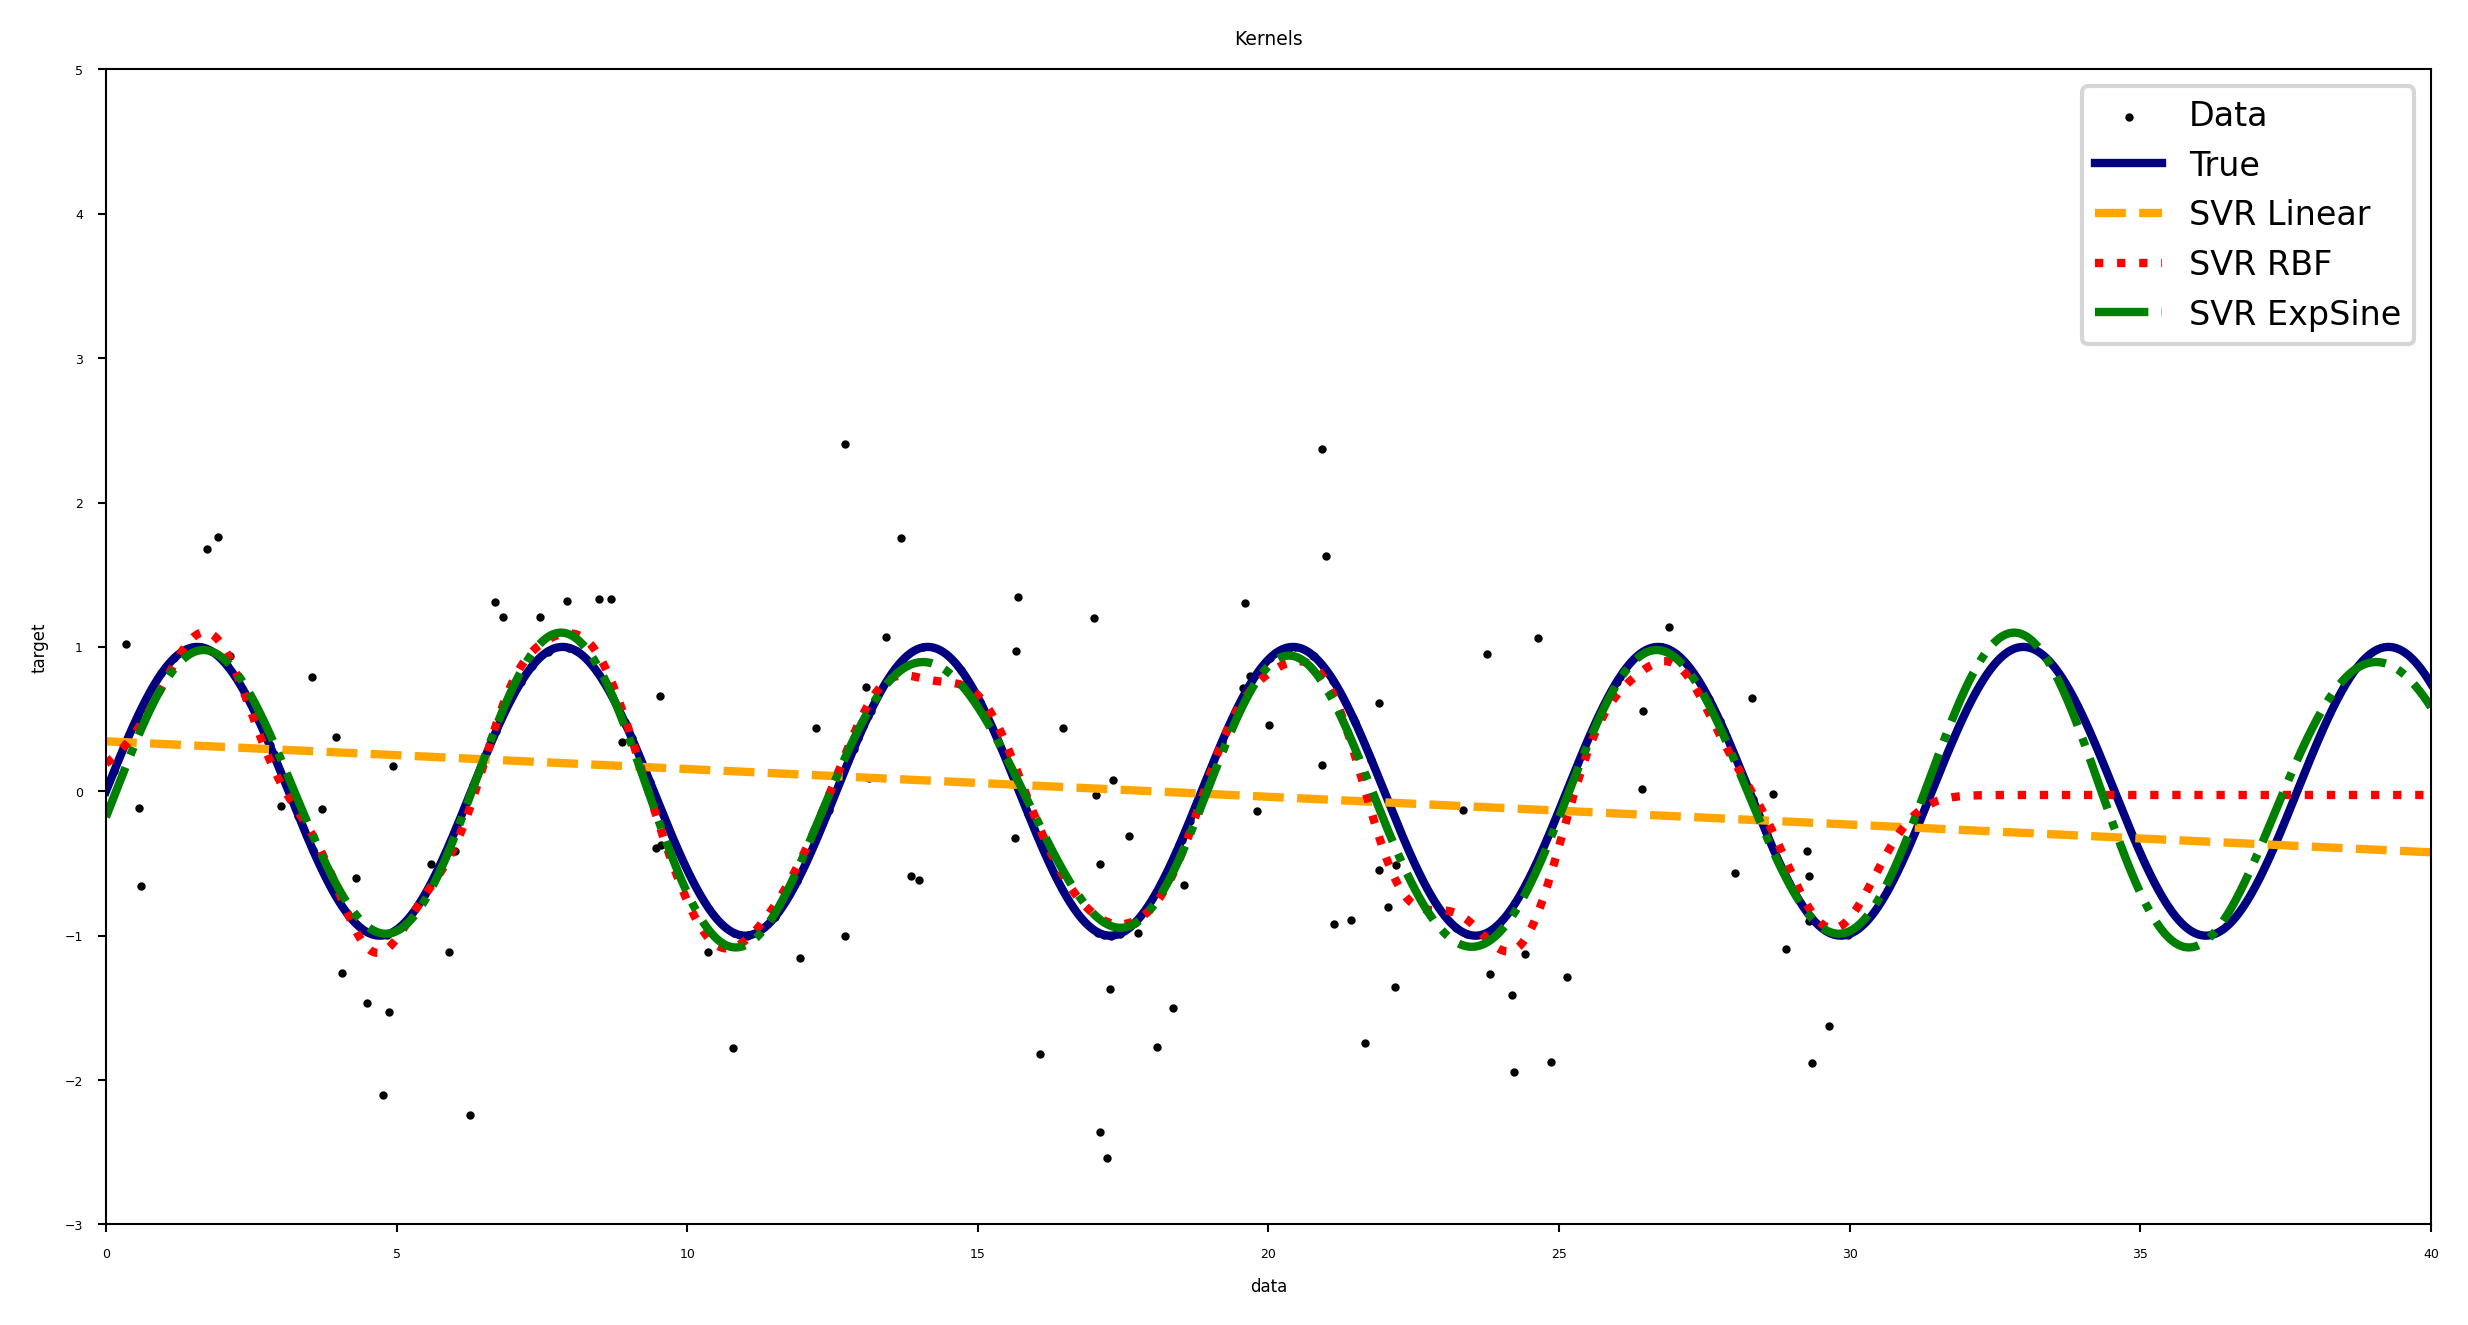

In [ ]:
from sklearn.svm import SVR
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, RationalQuadratic
from scipy.spatial.distance import pdist, cdist

# Kernels
def lin_kernel(X, Y):
    return np.dot(X, Y.T)

def poly_kernel(X, Y, degree=9): # Takes a *really* long time
    return np.dot(X, Y.T)**degree

def rbf_kernel(X, Y, gamma=1):
    dists = cdist(X, Y, metric='euclidean')
    return np.exp(- gamma * dists**2)

def expsine_kernel(X, Y, length_scale=0.4, periodicity=25):
    dists = cdist(X, Y, metric='euclidean')
    return np.exp(- 2 * (np.sin(np.pi / periodicity * dists) / length_scale) ** 2)

# Linear
svr_lin = SVR(kernel=lin_kernel, C=1)
svr_lin.fit(X, y)
y_svr_lin = svr_lin.predict(X_plot)

# Polynomial (skipping because very slow)
# svr_poly = SVR(kernel=poly_kernel, C=1)
# svr_poly.fit(X, y)
# y_svr_poly = svr_poly.predict(X_plot)

# RBF
svr_rbf = SVR(kernel=rbf_kernel)
svr_rbf.fit(X, y)
y_svr_rbf = svr_rbf.predict(X_plot)

# Periodic
svr2 = SVR(kernel=expsine_kernel)
svr2.fit(X, y)
y_svr2 = svr2.predict(X_plot)

# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y, color='navy', lw=lw, label='True')
plt.plot(X_plot, y_svr_lin, color='orange', lw=lw, label='SVR Linear')
# plt.plot(X_plot, y_svr_poly, color='blue', lw=lw, label='SVR Polynomial')
plt.plot(X_plot, y_svr_rbf, color='red', lw=lw, label='SVR RBF')
plt.plot(X_plot, y_svr2, color='green', lw=lw, label='SVR ExpSine')

plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 40)
plt.ylim(-3, 5)
plt.title('Kernels')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8});

Observations:  
- **Linear Kernel**: Obviously not the best fit.  
- **Polynomial Kernel**: Very slow to train (high-dimensional optimization space). Also requires careful tuning as it will underfit (degree too low) or overfit (degree to high) easily.  
- **RBF Kernel**: Works very nicely, but doesn't extrapolate well as the data points lose their influence rather quickly.  
- **ExpSine Kernel**: Works very nicely, capturing the periodicity perfectly. Indeed, this is exactly what this type of kernel is meant for.

## Kernel tuning
For ExpSine, we came up with good kernel parameters: length_scale=0.4, periodicity=25 rather magically (read: trial-and-error). We should tune these instead. We can do this by generating lots of kernels (with a closure) and then doing a grid search over the list.

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Closure to build a set of kernels
def build_kernel(length_scale, periodicity):
    def custom_kernel(X, Y, length_scale=length_scale, periodicity=periodicity):
        dists = cdist(X, Y, metric='euclidean')
        return np.exp(- 2 * (np.sin(np.pi / periodicity * dists) / length_scale) ** 2)
    return custom_kernel

# Builds list of kernels, using 10 values for length_scale and 10 values for periodicity
length_scale_range = np.linspace(0.1, 1, 10)
periodicity_range = np.linspace(1, 100, 9)
param_grid = {'kernel': [build_kernel(l, p) for l in length_scale_range for p in periodicity_range]}

grid_search_expsine = GridSearchCV(SVR(C=1), param_grid, cv=2, n_jobs=1)
grid_search_expsine.fit(X, y);

Best configuration: (0.2, 62.875)


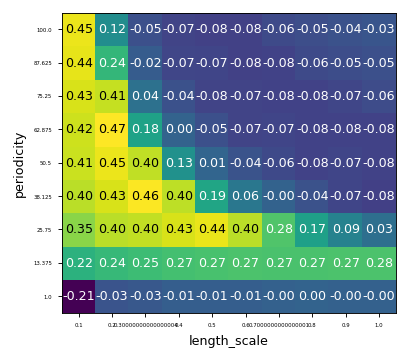

In [ ]:
import inspect
plt.rcParams['figure.dpi'] = 130
print('Best configuration:', inspect.getfullargspec(grid_search_expsine.best_params_['kernel']).defaults)

scores = np.array(grid_search_expsine.cv_results_['mean_test_score']).reshape(10,9).T
plt.rcParams['font.size']=7
mglearn.tools.heatmap(scores, xlabel='length_scale', xticklabels=length_scale_range,
                      ylabel='periodicity', yticklabels=periodicity_range, cmap="viridis");

Even though the grid search used a non-shuffled split of the data for validation, it may still overfit. Let's try a few of the best solutions, see the results below. While some other configurations got a slightly higher performance, they did not generate well to future examples.

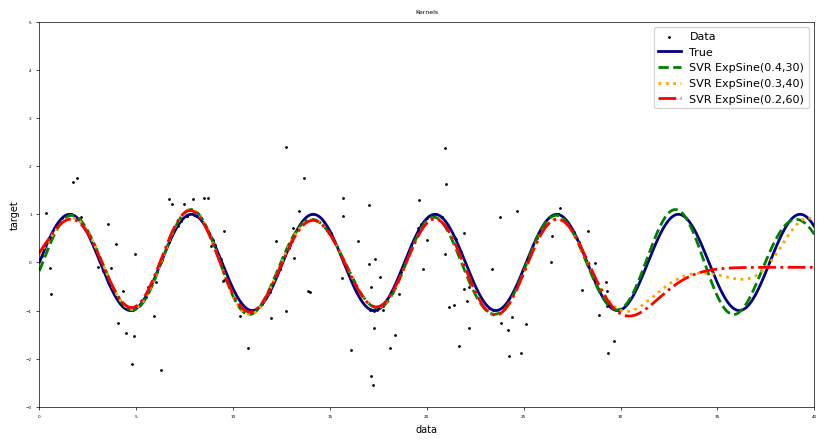

In [ ]:
svr_opt1 = SVR(kernel=build_kernel(0.4, 25)).fit(X, y).predict(X_plot)
svr_opt2 = SVR(kernel=build_kernel(0.3, 38)).fit(X, y).predict(X_plot)
svr_opt3 = SVR(kernel=build_kernel(0.2, 62)).fit(X, y).predict(X_plot)

# Plot results
plt.rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y, color='navy', lw=lw, label='True')
plt.plot(X_plot, svr_opt1, color='green', lw=lw, label='SVR ExpSine(0.4,30)')
plt.plot(X_plot, svr_opt2, color='orange', lw=lw, label='SVR ExpSine(0.3,40)')
plt.plot(X_plot, svr_opt3, color='red', lw=lw, label='SVR ExpSine(0.2,60)')
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 40)
plt.ylim(-3, 5)
plt.title('Kernels')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8});

## A more complex wave
We now make the problem a bit more challenging by adding an upward trend, and seeing whether our ExpSine kernel still works.

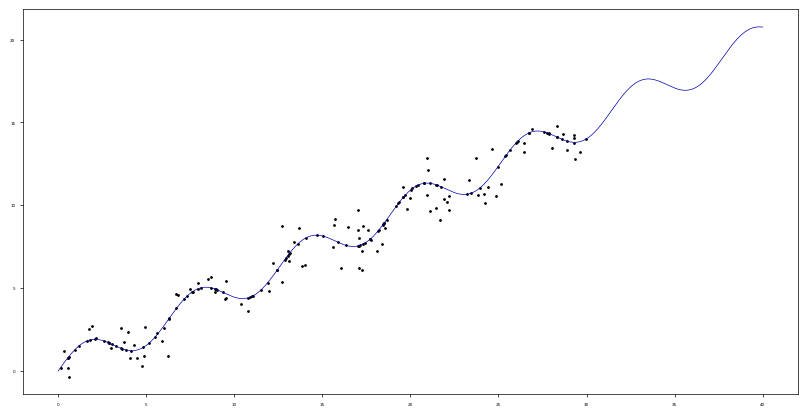

In [ ]:
# Generate sample data with added trend
rng = np.random.RandomState(0)
X = 30 * rng.rand(200, 1)
y = X.ravel()/2 + np.sin(X).ravel()
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2)  # add noise

X_plot = np.linspace(0, 40, 10000)[:, None]
true_y = X_plot/2 + np.sin(X_plot)

plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y);

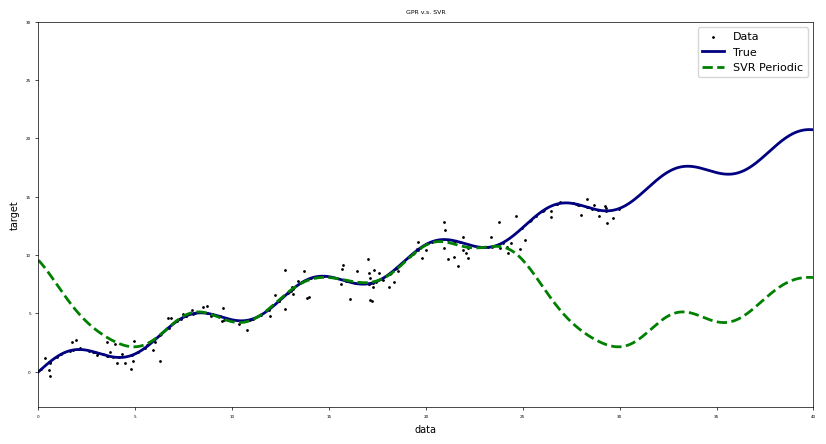

In [ ]:
from sklearn.svm import SVR
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, RationalQuadratic
from scipy.spatial.distance import pdist, cdist

def expsine_kernel(X,Y, length_scale=0.4, periodicity=25):
    dists = cdist(X, Y, metric='euclidean')
    return np.exp(- 2 * (np.sin(np.pi / periodicity * dists) / length_scale) ** 2)

# Periodic
svr2 = SVR(kernel=expsine_kernel)
svr2.fit(X, y)
y_svr2 = svr2.predict(X_plot)

# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y, color='navy', lw=lw, label='True')
plt.plot(X_plot, y_svr2, color='green', lw=lw, label='SVR Periodic')
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 40)
plt.ylim(-3, 30)
plt.title('GPR v.s. SVR')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8});

The SVR with periodic kernel fails now, because it can't adapt to the upward trend. The oscillation is kept, but it fails to fit the slower upward trend.

## Gaussian Processes
We can also use a Gaussian Process (GP) with the ExpSine kernel. When using a Gaussian Process, the kernel we pass (and its hyperparameters) defines the shape of the _prior_. The GP will optimize the kernel hyperparameters to fit the data (yielding the _posterior_), i.e. to optimize the _log-marginal likelihood_ of the GP's predictions given the data. Still, it is important to give a good starting point for the first iteration. Also, because the optimizer may get stuck in local minima, we can tell the GP to do a number of restarts with randomized initial hyperparameters.

Let's compare the SVM with the GP without doing anything fancy.

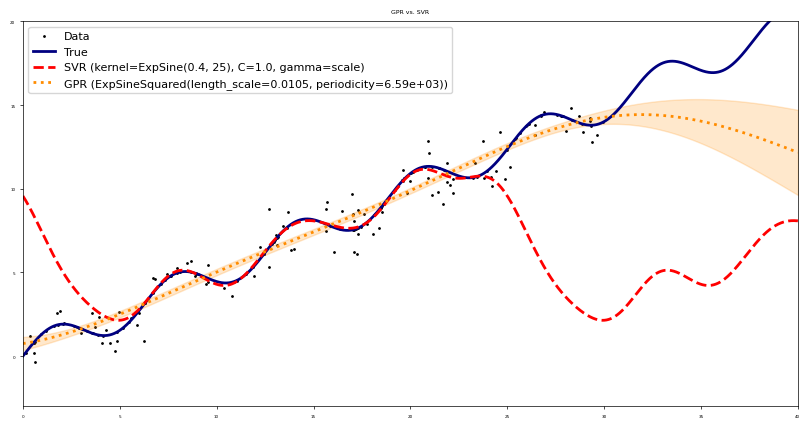

In [ ]:
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, RationalQuadratic

gp_expsine = ExpSineSquared(length_scale=0.4, periodicity=25) # pre-implemented ExpSine

# alpha is a regularizer. We also need normalize_y=True because or data is not centered around 0
gpr = GaussianProcessRegressor(kernel=gp_expsine, alpha=0.1, n_restarts_optimizer=9, normalize_y=True)
gpr.fit(X, y)
y_gpr, y_std = gpr.predict(X_plot, return_std=True)

# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y, color='navy', lw=lw, label='True')
svr_kernel = 'ExpSine'+str(inspect.getfullargspec(svr2.get_params()['kernel']).defaults)
plt.plot(X_plot, y_svr2, color='red', lw=lw, label='SVR (kernel=%s, C=%s, gamma=%s)' % (svr_kernel, svr2.get_params()['C'], svr2.get_params()['gamma']))
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw, label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange', alpha=0.2)

plt.xlim(0, 40)
plt.ylim(-3, 20)
plt.title('GPR vs. SVR')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8});

* The GP with the ExpSine kernel does a lot better than the SVR with the same kernel. It especially extrapolates a lot better, yet ultimately reverts to its prior (i.e. the average target value) when too far away from the last training points.

## Combining kernels
It is clear that the ExpSine kernel isn't sufficient to fit the data. We can, however, combine different kernels which each 'explain' part of the data:  
- RBF kernel for the long term rising trend
- ExpSine kernel for the periodic component
- WhiteKernel to explain the noise component

Interesting summary on combining kernels: https://www.cs.toronto.edu/~duvenaud/cookbook/

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF

k1 = 1000 * RBF(length_scale=100.0)  # long term smooth rising trend
k2 = 10 * RBF(length_scale=100.0) * ExpSineSquared(length_scale=1.0, periodicity=1.0)  # periodic component
k3 = 1 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.01)  # noise terms
k_mix = k1+k2+k3

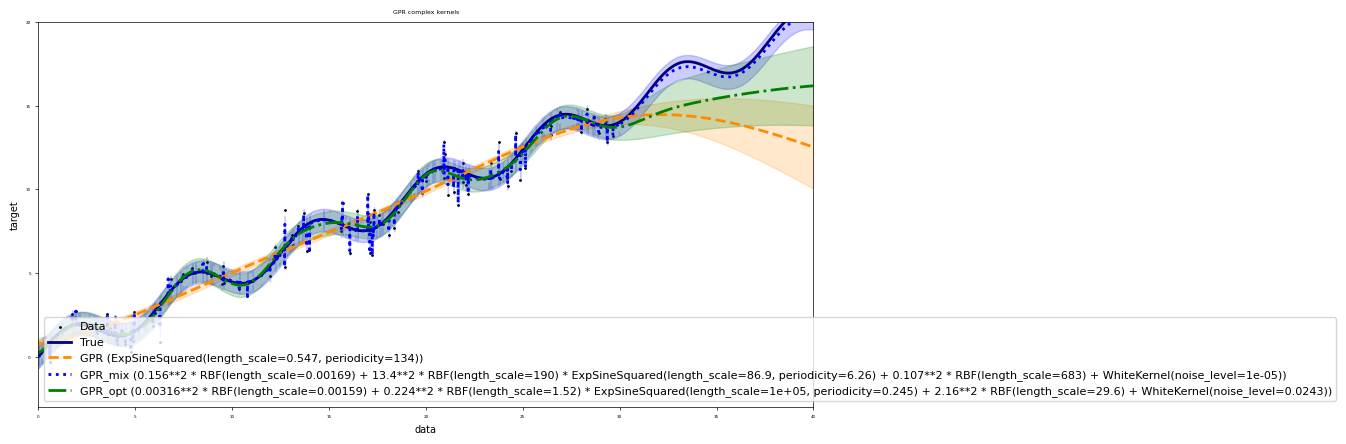

In [ ]:
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, RationalQuadratic

kernel_simple = ExpSineSquared(length_scale=0.4, periodicity=25) # periodic component

# Optimized parameters, because the k_mix settings above don't always converge to a good fit
ko1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
ko2 = 2.4**2 * RBF(length_scale=90.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0) # periodic component
ko3 = 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_opt = ko1 + ko2 + ko3

gpr = GaussianProcessRegressor(kernel=kernel_simple, alpha=0.1, normalize_y=True, n_restarts_optimizer=9)
gpr.fit(X, y)
y_gpr, y_std = gpr.predict(X_plot, return_std=True)

gpr2 = GaussianProcessRegressor(kernel=k_mix, alpha=0, normalize_y=True, n_restarts_optimizer=9)
gpr2.fit(X, y)
y_gpr2, y_std2 = gpr2.predict(X_plot, return_std=True)

gpr3 = GaussianProcessRegressor(kernel=kernel_opt, alpha=0, normalize_y=True, n_restarts_optimizer=9)
gpr3.fit(X, y)
y_gpr3, y_std3 = gpr3.predict(X_plot, return_std=True)

# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y, color='navy', lw=lw, label='True')
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw, label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange', alpha=0.2)
plt.plot(X_plot, y_gpr2, color='blue', lw=lw, label='GPR_mix (%s)' % gpr2.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr2 - y_std2, y_gpr2 + y_std2, color='blue', alpha=0.2)
plt.plot(X_plot, y_gpr3, color='green', lw=lw, label='GPR_opt (%s)' % gpr3.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr3 - y_std3, y_gpr3 + y_std3, color='green', alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 40)
plt.ylim(-3, 20)
plt.title('GPR complex kernels')
plt.legend(loc="lower left",  scatterpoints=1, prop={'size': 8});